In [1]:
import json
from tqdm import tqdm
from utils import (
    calc_iou, any_match,
    gen_froc_plot, gen_tabular_data,
    gen_precision_recall_plot,
    convert_to_tensor
)
import pandas as pd
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score
)
from monai.data.box_utils import non_max_suppression
import torch
import seaborn as sns
import numpy as np

In [2]:
files = [
    # 'pixel-parsed-mixed_test-overjoyed-hen-305',
    # 'pixel-parsed-mixed_test-indecisive-eel-172',
    # 'pixel-parsed-mixed_test-powerful-goat-766',
    # 'pixel-parsed-mixed_test-crawling-sloth-537',
    # 'pixel-parsed-all'
    'pixel-parsed-beautiful-fox-729',
    'pixel-parsed-fearless-eel-592',
    'pixel-parsed-thoughtful-cow-484',
    'pixel-parsed-enchanting-hare-280',
    'pixel-parsed-all'
]

In [3]:
all_fps_per_image = []
all_total_sensitivity = []
tabular_data = []
all_testy = []
all_lr_probs = []

composed_fp_probs = []
composed_tp_probs = []
composed_tp, composed_fp, composed_fn = 0, 0, 0
composed_testy = []
composed_lr_probs = []

for file_name in files:

    # output_path = '/data/output/validation/each_window/' # all datasets
    # output_path = '/data/output/validation/each_window/luna/' # only luna16
    # output_path = '/data/output/validation/each_window/hc/' # only hc
    # output_path = '/data/output/validation/each_window/msd/' # only msd

    # output_path = '/data/output/LUNA16_exp/' # all datasets
    # output_path = '/data/output/LUNA16_exp/luna/' # only luna16
    # output_path = '/data/output/LUNA16_exp/hc/' # only hc
    output_path = '/data/output/LUNA16_exp/msd/' # only hc

    data_list_file_path = f'{output_path}{file_name}.json'

    f = open(data_list_file_path)
    data = json.load(f)

    iou_thresh = 0.5 # same as Lucas
    # num_images = 155
    # num_targets = 313
    # num_images = 121 # 212 nodules LUNA16
    # num_targets = 273
    # num_images = 21 # HCFMRP
    # num_targets = 27
    # num_images = 13 # MSD
    # num_targets = 13

    # num_images = 155
    # num_targets = 385
    # num_images = 121 # LUNA16
    # num_targets = 364
    # num_images = 21 # HCFMRP
    # num_targets = 21
    num_images = 13 # MSD
    num_targets = 13

    fp_probs = []
    tp_probs = []
    tp, fp, fn = 0, 0, 0

    testy = []
    lr_probs = []

    for content in tqdm(data['test']):

        # convert pred_box to monai standard arrangement mode
        converted = convert_to_tensor(content['pred_box'])

        keep = non_max_suppression(
            converted, torch.tensor(content['score']), nms_thresh=0.1, max_proposals=100)

        # boxes_after_nms = content['pred_box'][keep]
        boxes_after_nms = [content['pred_box'][index] for index in keep]
        scores_after_nms = torch.tensor(content['score'])[keep]

        for pred_box, score in zip(boxes_after_nms, scores_after_nms):
            # if score > 0.5:
            iou = 0
            if any_match(content['true_box'][0], pred_box):
                iou = calc_iou(content['true_box'][0], pred_box)
            if iou >= iou_thresh:
                tp += 1
                tp_probs.append(score)
                composed_tp += 1
                composed_tp_probs.append(score)

                testy.append(1)
                lr_probs.append(score)
                composed_testy.append(1)
                composed_lr_probs.append(score)
            if iou < iou_thresh and iou > 0:
                fp += 1
                fp_probs.append(score)
                composed_fp += 1
                composed_fp_probs.append(score)

                testy.append(0)
                lr_probs.append(score)
                composed_testy.append(0)
                composed_lr_probs.append(score)
            if iou == 0:
                fn += 1
                composed_fn += 1

                testy.append(0)
                lr_probs.append(score)
                composed_testy.append(0)
                composed_lr_probs.append(score)

    fps_per_image, total_sensitivity, precision, recall, p1, p2, p3, p4, p5, p6 ,p7, cpm = gen_tabular_data(
        tp, fp, fn, fp_probs, tp_probs, num_images, num_targets
    )

    all_fps_per_image.append(fps_per_image)
    all_total_sensitivity.append(total_sensitivity)
    all_testy.append(testy)
    all_lr_probs.append(lr_probs)

    tabular_data.append({
        # "precision": precision,
        # "recall": recall,
        # "tp": tp,
        # "fn": fn,
        # "fp": fp,
        "1/8": p1,
        "1/4": p2,
        "1/2": p3,
        "1": p4,
        "2": p5,
        "4": p6,
        "8": p7,
        "CPM": cpm,
        # "AP": str(average_precision_score(testy, lr_probs))
    })

first_table = pd.DataFrame(tabular_data)

100%|██████████| 13/13 [00:00<00:00, 41.95it/s]


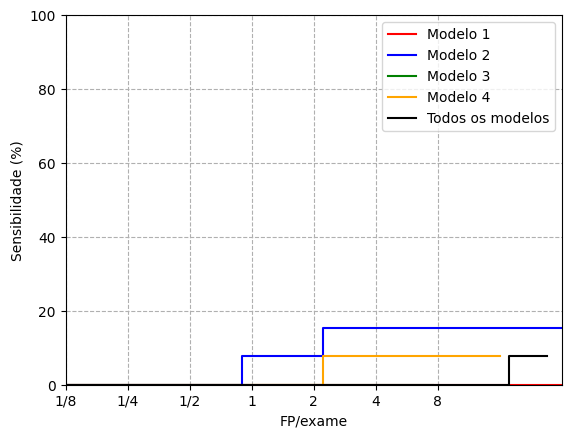

In [4]:
gen_froc_plot(all_fps_per_image, all_total_sensitivity)

In [5]:
first_table

,1/8,1/4,1/2,1,2,4,8,CPM
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.076923,0.153846,0.032967
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.076923,0.010989
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.076923,0.010989


<Axes: >

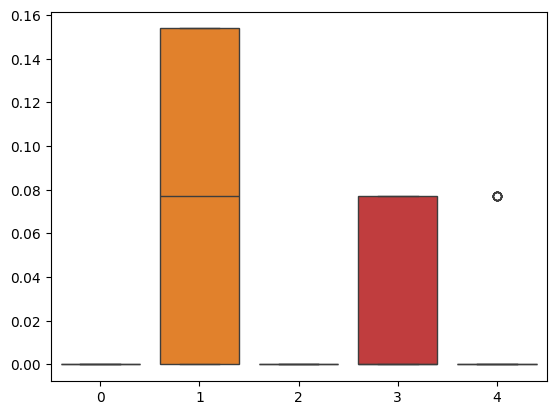

In [6]:
sns.boxplot(data=all_total_sensitivity)

In [7]:
df = pd.DataFrame([all_total_sensitivity], columns=['a1', 'a2', 'a3', 'a4', 'all'])
df.to_excel(output_path + 'all_total_sensitivity.xlsx', index=False)
df.head()

,a1,a2,a3,a4,all
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.15384615384615385, 0.15384615384615385, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07692307692307693, 0.07692307692307693, 0.0...","[0.07692307692307693, 0.07692307692307693, 0.0..."


In [8]:
# gen_precision_recall_plot(precision_recall_curve, all_testy, all_lr_probs)